## Multi-Asset Efficient Frontier Analysis:

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as scs  

In [2]:
ret = pd.read_csv("data/IndustryPortfolios.xlsx.csv",
                 header=0, index_col=0)/100   #percentage to decimals right away
ret.index=pd.to_datetime(ret.index,format="%Y%m").to_period("m")
ret.columns=ret.columns.str.strip()

In [3]:
n_years=ret["2002":].shape[0]/12 #number of months/12
eret=((1+ret["2002":]).prod())**(1/n_years)-1 #annualized expected returns
cov=ret["2002":].cov()*12 #.cov() covariance matrix monthly*12--> annualized covariance


In [4]:
l=["Food","Soda","Toys","Fun","Books","Clths","Rtail","Fin","Gold","Comps"]
eret[l]
cov.loc[l,l]

,Food,Soda,Toys,Fun,Books,Clths,Rtail,Fin,Gold,Comps
Food,0.015987,0.014128,0.015303,0.017767,0.015322,0.014606,0.011485,0.015126,0.006392,0.013886
Soda,0.014128,0.039114,0.021884,0.028954,0.022458,0.022966,0.015746,0.021919,0.006744,0.019251
Toys,0.015303,0.021884,0.062910,0.045793,0.035725,0.038446,0.027974,0.037835,0.015421,0.032587
Fun,0.017767,0.028954,0.045793,0.084375,0.046380,0.045188,0.033750,0.048267,0.014153,0.042959
Books,0.015322,0.022458,0.035725,0.046380,0.049721,0.033768,0.024613,0.037471,0.010102,0.031242
Clths,0.014606,0.022966,0.038446,0.045188,0.033768,0.048098,0.027810,0.035096,0.006429,0.031651
Rtail,0.011485,0.015746,0.027974,0.033750,0.024613,0.027810,0.028192,0.027015,0.006865,0.024816
Fin,0.015126,0.021919,0.037835,0.048267,0.037471,0.035096,0.027015,0.052521,0.010013,0.037811
Gold,0.006392,0.006744,0.015421,0.014153,0.010102,0.006429,0.006865,0.010013,0.129780,0.008896
Comps,0.013886,0.019251,0.032587,0.042959,0.031242,0.031651,0.024816,0.037811,0.008896,0.048790


In [5]:
#build functions for portfolio returns and portfolio volatility
def portfolio_ret(weights, returns):
    return weights.T@returns    

In [6]:
def portfolio_vol(weights,covmat):
    return (weights.T@covmat@weights)**.5 #or use np.sqrt()

In [7]:
from scipy.optimize import minimize

In [8]:
def minimize_vol(target_return,ereturns,covmat):
    """
    target return--> weights in a minimum-variance portfolio that generates target return
    """
    n=ereturns.shape[0] #number of assets
    init_values=np.repeat(1/n,n) #an array of numbers
    
    bounds=((0,1),)*n  #an array on n elements(tuples)  0<each weights<1
    
    #Constraints:
    weights_sum_to_1={'type':'eq',
                     'fun':lambda weights:np.sum(weights)-1}
    return_is_target={'type':'eq',
                     'args':(ereturns,),
                     'fun':lambda weights,ereturns: portfolio_ret(weights,ereturns)-target_return}
    
    results=minimize(portfolio_vol,
                    init_values,
                    args=(covmat),
                    method='SLSQP',   #Sequential least Squares of quadratic problems?
                    bounds=bounds,
                    constraints=(weights_sum_to_1,return_is_target),
                    options={'disp':False}) 
    weights=results.x  #The solution(output)
    return weights
    

In [9]:
w11=minimize_vol(0.11,eret[l],cov.loc[l,l])
w11

array([4.39539893e-17, 4.20839404e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.06267367e-01, 7.28932287e-02, 9.28301722e-17,
       2.08406124e-16, 0.00000000e+00])

In [10]:
portfolio_ret(w11,eret[l])

0.10999999998106653

In [11]:
portfolio_vol(w11,cov.loc[l,l])

0.17947022261634613

In [12]:
def optimal_weights(n_points,ereturns,covmat):
    """
    takes expected returns and vols + # of gridpoints--> weights of the efficient frontier portfolio
    """
    target_returns=np.linspace(ereturns.min(),ereturns.max(),n_points)
    optimal_weights=[minimize_vol(tr,ereturns,covmat) for tr in target_returns]
    
    return optimal_weights

<Axes: xlabel='V'>

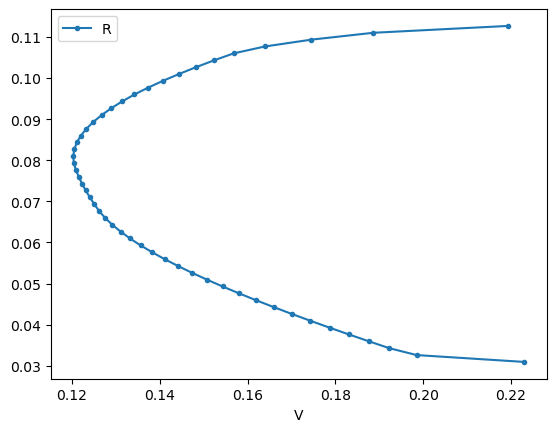

In [13]:
efweights=optimal_weights(50,eret[l],cov.loc[l,l])
pret=[portfolio_ret(w,eret[l]) for w in efweights]
pvol=[portfolio_vol(w,cov.loc[l,l]) for w in efweights]

ef=pd.DataFrame({"R": pret,
               "V": pvol})
ef.plot.line(x="V",y="R",style=".-")

In [26]:
#ef.sort_values(by='R')
#ef.sort_values(by='V')

## Global Minimum Variance Portfolio: 

In [32]:
def gmv(ereturns, covmat):
    """
    Optimal weights for the GMV portfolio.
    """
    n = ereturns.shape[0]  # Number of assets
    init_values = np.repeat(1/n, n)  # Initial guess for weights
    
    bounds = ((0, 1),) * n  # Bounds for weights (0 <= weight <= 1 for each asset)
    
    # Constraint: Weights sum to 1
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1}
  
    # Perform optimization
    results = minimize(portfolio_vol, 
                       init_values, 
                       args=(covmat),
                       method='SLSQP', 
                       bounds=bounds, 
                       constraints=[weights_sum_to_1],
                       options={'disp': False})
    
    weights = results.x  # Extract optimal weights
    
    return weights

In [33]:
GMV_weights=gmv(eret[l],cov.loc[l,l])
GMV_weights

array([7.23461694e-01, 2.00360752e-02, 3.57786717e-18, 0.00000000e+00,
       9.43255890e-18, 3.68628739e-18, 1.90960997e-01, 4.11996826e-18,
       6.55412338e-02, 0.00000000e+00])

In [34]:
portfolio_ret(GMV_weights,eret[l])

0.08067297224187908

In [35]:
portfolio_vol(GMV_weights,cov.loc[l,l])

0.12028300488985476

## Maximum Sharpe Ratio Portfolio: 

In [49]:
# -Sharpe ratio function
def negative_sharpe_ratio(weights, ereturns, covmat,risk_free_rate):
    portfolio_return = portfolio_ret(weights, ereturns)
    portfolio_volatility = portfolio_vol(weights, covmat)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio

In [50]:
def msr(ereturns, covmat, risk_free_rate):
    """
    Weights for the MSR portfolio.
    """
    n = ereturns.shape[0]  # Number of assets
    init_values = np.repeat(1/n, n)  # Initial guess for weights
    
    bounds = ((0, 1),) * n  # Bounds for weights (0 <= weight <= 1 for each asset)
    
    # Constraint: Weights sum to 1
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1}
      
    # Perform optimization
    results = minimize(negative_sharpe_ratio,
                       init_values,
                       args=(ereturns, covmat, risk_free_rate),
                       method='SLSQP', 
                       bounds=bounds, 
                       constraints=[weights_sum_to_1],
                       options={'disp': False})
    
    weights = results.x  # Extract optimal weights
    
    return weights

In [51]:
#Assuming that the risk-free rate is 3%
rf=0.03
MSR_weights=msr(eret[l],cov.loc[l,l],rf)
MSR_weights

array([2.41998395e-01, 2.80719895e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.85872582e-04, 4.76295837e-01, 0.00000000e+00,
       0.00000000e+00, 7.58507840e-16])

In [52]:
portfolio_ret(MSR_weights,eret[l])

0.09835506266204155

In [53]:
portfolio_vol(MSR_weights,cov.loc[l,l])

0.13870073845670564